In [1]:
using Pkg
Pkg.activate(ENV["PYTHON_JULIAPKG_PROJECT"])

  Activating project at `~/miniforge3/envs/rmg_electrocat_2/julia_env`


In [2]:
using ReactionMechanismSimulator

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Replacing docs for `ReactionMechanismSimulator.getpairs :: Tuple{T} where T<:ReactionMechanismSimulator.AbstractReaction` in module `ReactionMechanismSimulator`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `ReactionMechanismSimulator.getsimilarity :: Union{Tuple{T2}, Tuple{T}, Tuple{T, T2}} where {T<:ReactionMechanismSimulator.AbstractSpecies, T2<:ReactionMechanismSimulator.AbstractSpecies}` in module `ReactionMechanismSimulator`
└ @ Base.Docs docs/Docs.jl:243
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Module Symbolics with build ID ffffffff-ffff-ffff-da52-b0f537dfbdbc is missing from the cache.
│ This ma

In [3]:
using PythonPlot
using DifferentialEquations
using Sundials
using SciMLBase
using QuadGK

In [4]:
outdict = readinput("Ag_C2_042925.rms")

[18:17:43] WARNING: not removing hydrogen atom without neighbors
[18:17:43] WARNING: not removing hydrogen atom without neighbors
┌ Warning: failed to generate StokesDiffusivity model for species vacantX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CHO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2HX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species OCX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.j

Dict{Any, Any} with 4 entries:
  "Solvents"              => Solvent[Solvent("water", RiedelViscosity{Float64}(…
  Set(["surface", "gas"]) => Dict{Any, Any}("Reactions"=>ElementaryReaction[vac…
  "gas"                   => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…
  "surface"               => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…

In [5]:
boundarylayerspcs = outdict["gas"]["Species"]
boundarylayerrxns = outdict["gas"]["Reactions"]
surfspcs = outdict["surface"]["Species"]
surfrxns = outdict["surface"]["Reactions"]
interfacerxns = outdict[Set(["surface", "gas"])]["Reactions"]
solv = outdict["Solvents"][1];

In [6]:
sitedensity = 2.294e-5; # Ag111 site density is 2.294e-9 mol/cm^2 or 2.294e-5 mol/m^2
boundarylayer = IdealDiluteSolution(boundarylayerspcs,boundarylayerrxns,solv,name="boundarylayeruid",diffusionlimited=true);
surf = IdealSurface(surfspcs,surfrxns,sitedensity,name="surface");

In [7]:
# Reservoir is a 100 mL (100e-6 m^3) cell
# Proton concentration is 10^-7 mol/L (10^-4 mol/m^3)
# CO2 concentration is 0.01 mol/L (10 mol/m^3), saturation solubility ~0.03 mol/L
# AVratio in experiments is 36 m^-1 but is measured by surface area/reservoir volume
# Area of the electrode is therefore 3.6e1 m^-1 * 1e2 * 1e-6 m^3 = 3.6e-3 m^2 = 36 cm^2
# Assume boundary layer thickness d_bl = 1 mm or 1e-3 m
# Volume of the boundary layer V_bl = 3.6e-3 m^2 * 1e-3 m = 3.6e-6 m^3
# Actual AVratio is therefore 3.6e-3 m^2 / 3.6e-6 m^3 = 1e3 m^-1 (reciprocal of d_bl)
# Amount of sites is 2.943e-5 mol/m^2 * 3.6e-3 m^2 = 10.595e-8 mol

C_proton = 1e-7*1e3;
C_co2 = 1e-2*1e3;
C_default = 1e-12;
V_res = 1e3;
layer_thickness = 1e-3;
A_surf = V_res*36;
V_bl = A_surf*layer_thickness;
# V_bl = V_res;
sites = sitedensity*A_surf;

# The initial conditions for individual species are moles not concentration, so we need to multiply concentration by boundary layer volume
initialcondsboundarylayer = Dict(["proton"=>C_proton*V_bl,
                                  "CO2"=>C_co2*V_bl,
                                #   "H2"=>C_default*10*V_bl,
                                #   "O=CO"=>C_default*V_bl,
                                  "V"=>V_bl,"T"=>300,"Phi"=>0.0,"d"=>0.0]);
initialcondsreservoir = Dict(["proton"=>C_proton,
                              "CO2"=>C_co2,
                              "V"=>V_res,"T"=>300]);


# Assume voltage is -1.0 V vs. R.H.E. which equates to -1.414 V vs. S.H.E. at pH=7
initialcondssurf = Dict(["CO2X"=>0.4*sites,
        # "CHO2X"=>0.1*sites,
        # "CO2HX"=>0.1*sites,
        # "OX"=>0.1*sites,
        # "OCX"=>0.1*sites,
        "vacantX"=>0.6*sites,
        # "CH2O2X"=>0.05*sites,
        # "CHOX"=>0.04*sites,
        # "CH2OX"=>0.01*sites,
        "A"=>A_surf,"T"=>300,"Phi"=>-1.414]);

In [8]:
domainboundarylayer, y0boundarylayer, pboundarylayer = ConstantTVDomain(phase=boundarylayer, initialconds=initialcondsboundarylayer);
domaincat,y0cat,pcat = ConstantTAPhiDomain(phase=surf,
    initialconds=initialcondssurf);

In [9]:
inter,pinter = ReactiveInternalInterfaceConstantTPhi(domainboundarylayer,
  domaincat,interfacerxns,298.15,A_surf);

In [10]:
# start with 1mm layer thickness
diffusionlayer = ConstantReservoirDiffusion(domainboundarylayer, initialcondsreservoir, A_surf, layer_thickness);

In [11]:
interfaces = [inter,diffusionlayer];

In [12]:
@time react,y0,p = Reactor((domainboundarylayer,domaincat), (y0boundarylayer,y0cat), (0.0, 1e3), interfaces, (pboundarylayer,pcat,pinter));

 10.585216 seconds (18.03 M allocations: 1.160 GiB, 4.27% gc time, 99.87% compilation time: <1% of which was recompilation)


In [13]:
fieldnames(typeof(react.ode))

(:f, :u0, :tspan, :p, :kwargs, :problem_type)

In [14]:
fieldnames(typeof(react.ode.f.f))

(:domains, :interfaces)

In [15]:
react.ode.f.f

(::ReactionMechanismSimulator.var"#dydt#616"{Tuple{ConstantTVDomain{IdealDiluteSolution{Tuple{}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}, ConstantTAPhiDomain{IdealSurface{Tuple{Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}, ReactionMechanismSimulator.NASAvec{EmptyThermoUncertainty}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}}, Vector{Any}}) (generic function with 1 method)

In [16]:
@time sol = solve(react.ode,Sundials.CVODE_BDF(),abstol=1e-20,reltol=1e-8);
println(sol.t[end]);
println(sol.retcode);

  5.706378 seconds (5.22 M allocations: 595.831 MiB, 2.44% gc time, 93.39% compilation time)
1000.0
Success


In [17]:
ssys = SystemSimulation(sol,(domainboundarylayer,domaincat,), interfaces,p);

In [18]:
concentrations(ssys.sims[1], 1e3)

25-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 9.995894322983263
 1.9009994446410727e-15
 0.0
 3.2837017585781954e-9
 7.457566298864922e-6
 5.088457912314128e-31
 ⋮
 1.0146040082645551e-15
 8.751521312671633e-12
 6.433071959568614e-16
 7.881294843165944e-11
 7.705460739893599e-11
 2.467809485838953e-15
 1.5818822088345775e-28
 1.4563077738483654e-20
 2.9286296106950514e-32

In [19]:
"""
diffusive flux to the reservoir
"""
function flux_to_reservoir(sim,t,reservoirinterface)
    cs = concentrations(sim,t)
    # println(reservoirinterface.A);
    # println(reservoirinterface.layer_thickness);
    # println(sim.domain.diffusivity);
    # println(cs);
    # println(reservoirinterface.c);
    return reservoirinterface.A .* sim.domain.diffusivity .* (cs - reservoirinterface.c) / reservoirinterface.layer_thickness
end

"""
Integrates the flux to the reservoir and computes the concentration assuming
there is no prior concentration of that species in the reservoir
"""
function get_reservoir_concentration(sim,t,reservoirinterface,Vres)
    intg,err = quadgk(x -> flux_to_reservoir(sim,x,reservoirinterface), 0, t);
    return intg./Vres
end

get_reservoir_concentration

In [20]:
# Logarithmic time scale
t_vals = 10 .^ range(-12, stop=3, length=100);

# Compute reservoir concentrations
flux_vals = [flux_to_reservoir(ssys.sims[1], t, diffusionlayer) for t in t_vals]
# conc_vals = [get_reservoir_concentration(ssys.sims[1], t, diffusionlayer, V_res) for t in t_vals]
conc_vals_bl = [concentrations(ssys.sims[1], t) for t in t_vals]
flux_matrix = hcat(flux_vals...);
# conc_matrix = hcat(conc_vals...);
conc_matrix_bl = hcat(conc_vals_bl...);


In [21]:
flux_matrix

25×100 Matrix{Float64}:
  0.0           0.0           0.0          …   0.0           0.0
  0.0           0.0           0.0              0.0           0.0
  0.0           0.0           0.0              0.0           0.0
  0.0           0.0           0.0              0.0           0.0
 -1.10653e-10  -1.56848e-10  -2.22328e-10     -0.000230735  -0.000165936
 -2.39182e-10  -3.39032e-10  -4.80563e-10  …  -5.97126e-6   -5.97126e-6
  0.0           0.0           0.0              0.0           0.0
  2.45652e-31   4.93562e-31   9.91657e-31      8.72626e-11   1.35284e-10
  2.19873e-27   6.59934e-27   2.01542e-26      2.36514e-7    2.8743e-7
  1.45136e-91   8.2261e-91    4.67978e-90     -5.82143e-30   2.37233e-32
  ⋮                                        ⋱                
  1.78663e-57   1.96363e-56   2.24754e-55      2.47709e-17   3.58097e-17
  5.28216e-59   1.08752e-57   2.63488e-56      1.62428e-13   2.99043e-13
  4.31419e-56   8.9391e-55    2.31362e-53      2.12449e-17   2.19821e-17
  5.37499

In [22]:
conc_matrix_bl

25×100 Matrix{Float64}:
  0.0           0.0           0.0          …   0.0          0.0
  0.0           0.0           0.0              0.0          0.0
  0.0           0.0           0.0              0.0          0.0
  0.0           0.0           0.0              0.0          0.0
 10.0          10.0          10.0              9.99429      9.99589
  9.9996e-5     9.99943e-5    9.9992e-5    …   1.89928e-15  1.901e-15
  0.0           0.0           0.0              0.0          0.0
  5.96264e-30   1.19801e-29   2.40702e-29      2.1181e-9    3.2837e-9
  5.70475e-26   1.71224e-25   5.22913e-25      6.13652e-6   7.45757e-6
  3.11306e-90   1.76443e-89   1.00378e-88     -1.24865e-28  5.08846e-31
  ⋮                                        ⋱                
  5.06209e-56   5.56359e-55   6.368e-54        7.01839e-16  1.0146e-15
  1.54583e-57   3.18264e-56   7.71101e-55      4.75348e-12  8.75152e-12
  1.26255e-54   2.61604e-53   6.77083e-52      6.21734e-16  6.43307e-16
  1.57299e-56   2.4959e-55   

In [23]:
# clf()

# for i in 1:size(conc_matrix, 1)
#     if maximum(conc_matrix[i, :]) > 1e-12
#         plot(t_vals, conc_matrix[i, :], label=ssys.sims[1].domain.phase.species[i].name)

#     end
# end

# xscale("log")
# yscale("log")
# xlabel("Time (s)")
# ylabel("Reservoir Concentration")
# legend()
# tight_layout()
# gcf()

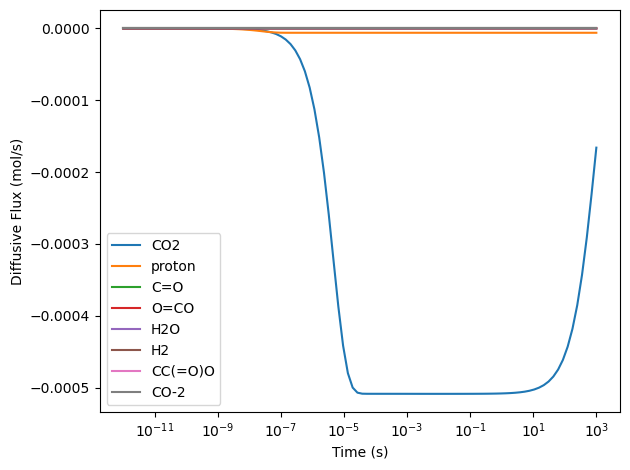

In [24]:
clf()

for i in 1:size(flux_matrix, 1)
    if abs(maximum(flux_matrix[i, :])) > 1e-12
        plot(t_vals, flux_matrix[i, :], label=ssys.sims[1].domain.phase.species[i].name)

    end
end

xscale("log")
# yscale("log")
xlabel("Time (s)")
ylabel("Diffusive Flux (mol/s)")
legend()
tight_layout()
gcf()

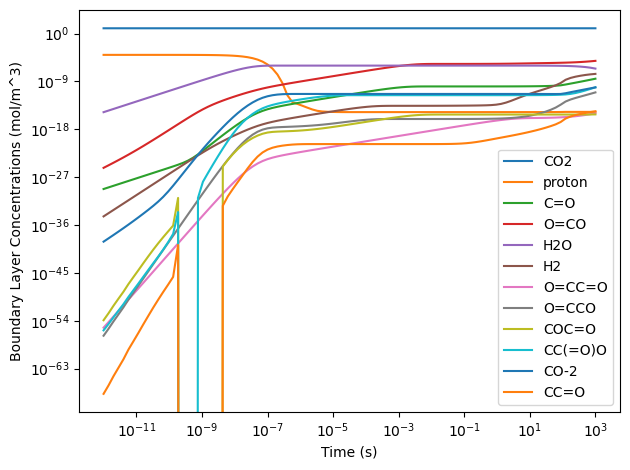

In [25]:
clf()
for i in 1:size(conc_matrix_bl, 1)
    if maximum(conc_matrix_bl[i, :]) > 1e-16
        plot(t_vals, conc_matrix_bl[i, :], label=ssys.sims[1].domain.phase.species[i].name)

    end
end

xscale("log")
yscale("log")
xlabel("Time (s)")
ylabel("Boundary Layer Concentrations (mol/m^3)")
legend()
tight_layout()
gcf()

In [26]:
flux_to_reservoir(ssys.sims[1],1e-12,diffusionlayer)

25-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
 -1.1065307558934541e-10
 -2.391819083649919e-10
  0.0
  2.456515040239678e-31
  2.1987305985554648e-27
  1.4513644535895097e-91
  ⋮
  1.786626313652337e-57
  5.282160782532602e-59
  4.314185572755859e-56
  5.374985999598471e-58
  2.9488771690448566e-41
  6.484884569806172e-70
  4.38489673445632e-65
  5.301357962680641e-71
  3.749885553130054e-81

In [27]:
@time res_cs = get_reservoir_concentration(ssys.sims[1],1e3,diffusionlayer,V_res)

  1.568176 seconds (808.83 k allocations: 53.710 MiB, 99.99% compilation time)


25-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
 -0.000305933766239202
 -5.971264518408162e-6
  0.0
  6.061356878812117e-11
  1.994776218890955e-7
  3.6506732267198526e-28
  ⋮
  1.8530468439250678e-17
  1.0892828492137514e-13
  2.1047306379836483e-17
  9.40818406475637e-13
  1.3923059994803368e-12
  4.236901789426139e-17
  2.5738223985740063e-30
  1.7268159892614905e-22
  1.9462281666180405e-33

In [28]:
sort(res_cs)

25-element Vector{Float64}:
 -0.000305933766239202
 -5.971264518408162e-6
  0.0
  0.0
  0.0
  0.0
  0.0
  1.5871699271786366e-53
  1.9462281666180405e-33
  2.5738223985740063e-30
  ⋮
  2.1047306379836483e-17
  4.236901789426139e-17
  1.0892828492137514e-13
  9.40818406475637e-13
  1.3923059994803368e-12
  6.061356878812117e-11
  8.320806506357228e-10
  2.614714710578341e-8
  1.994776218890955e-7

In [29]:
getfield.(ssys.sims[1].domain.phase.species,:name)

25-element Vector{String}:
 "Ar"
 "He"
 "Ne"
 "N2"
 "CO2"
 "proton"
 "H"
 "C=O"
 "O=CO"
 "O2"
 ⋮
 "O=CC=O"
 "O=CCO"
 "COC=O"
 "CC(=O)O"
 "CO-2"
 "CC=O"
 "OCO"
 "OCCO"
 "C=C"

In [30]:
getfield.(ssys.sims[2].domain.phase.species,:name)

76-element Vector{String}:
 "vacantX"
 "CO2X"
 "CHO2X"
 "CO2HX"
 "OCX"
 "OX"
 "CH2O2X"
 "CHOX"
 "CH2OX"
 "HOX"
 ⋮
 "CC#[Pt]"
 "[Pt]C#CO[Pt]"
 "[Pt]OC#CO[Pt]"
 "COC=O.[Pt]"
 "O=COC[Pt]"
 "O=COC=[Pt]"
 "O=COC#[Pt]"
 "[Pt]C=C=[Pt]"
 "[Pt]=CC=[Pt]"

In [31]:
# Helper function
function plotX(sim, tol, t_end, exclude)
    clf()
    xs = molefractions(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Mole Fraction")
end

plotX (generic function with 1 method)

In [32]:
# Helper function
function plotC(sim, tol, t_end, exclude)
    clf()
    xs = concentrations(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Concentration")
end

plotC (generic function with 1 method)

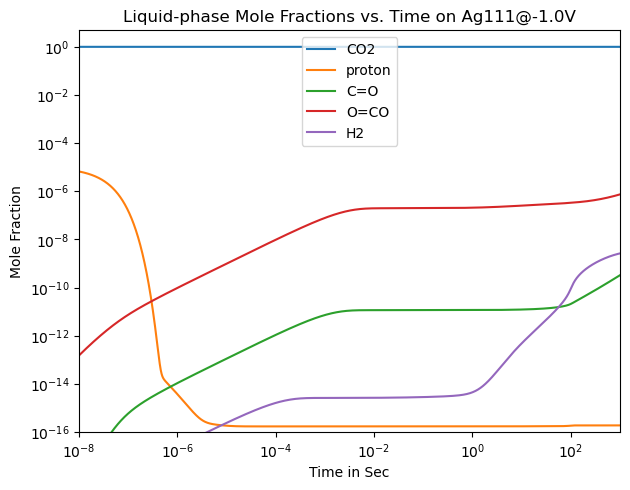

In [33]:
exclude_species = ["H2O"]
plotX(ssys.sims[1], 1e-10, 1e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-8, 1e3)
ylim(1e-16, 5)
title("Liquid-phase Mole Fractions vs. Time on Ag111@-1.0V")
gcf()

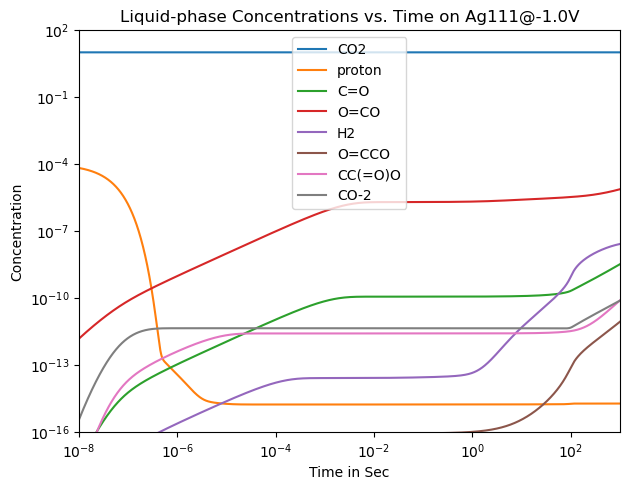

In [34]:
exclude_species = ["H2O"]
plotC(ssys.sims[1], 1e-12, 1e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-8, 1e3)
ylim(1e-16, 1e2)
title("Liquid-phase Concentrations vs. Time on Ag111@-1.0V")
gcf()

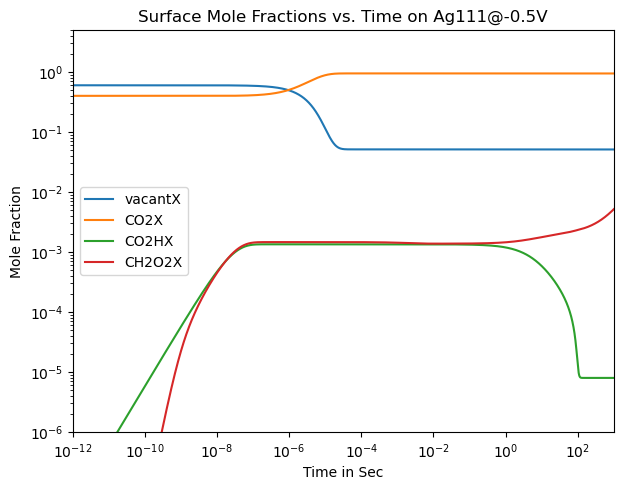

In [35]:
exclude_species = ["H2O"]
plotX(ssys.sims[2], 1e-4, 1e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e3)
ylim(1e-6, 5)
title("Surface Mole Fractions vs. Time on Ag111@-0.5V")
gcf()

In [36]:
getfluxdiagram(ssys,1e3;speciesratetolerance=1e-8)

PythonCall.Core.PyException: Python: TypeError: cannot use a string pattern on a bytes-like object

In [37]:
function plotROP(ssys,name,t;N=0,tol=0.01)
    clf()
    rop = rops(ssys, name, t)
    inds = rop.nzind[reverse(sortperm(abs.(rop.nzval)))]
    if N == 0
        N = length(inds)
    elseif N > length(inds)
        N = length(inds)
    end
    inds = inds[1:N]
    mval = abs(rop[inds[1]])
    minval = mval*tol
    k = 1
    while k < length(inds) && abs(rop[inds[k]]) >= minval
        k += 1
    end
    inds = inds[1:k]
    net_rops = sum(rop[inds])
    println("Net ROPs for species $name is: $net_rops")

    for (i, j) in enumerate(inds)
        println("Showing the reaction with $i th highest ROP for species $name:")
        println(getrxnstr(ssys.reactions[j]))
        println("ROP = ", rop[inds[i]])
        println(ssys.reactions[j].kinetics)
    end

    xs = Array{Float64,1}(1:length(inds))
    barh(xs,reverse(rop[inds]))
    yticks(xs,reverse(getrxnstr.(ssys.reactions[inds])))
    xlabel("Production/Loss Rate mol/s")
    gcf()
end

plotROP (generic function with 1 method)

In [38]:
function PrintKinDetail(inter, speciesname)
    println("Showing Kinetics details for reactions involving species $speciesname\n")
    for (i,rxn) in enumerate(inter.reactions)
        flag = false
        for j = 1:length(rxn.reactants)
            if rxn.reactants[j].name == speciesname
                flag = true
            end
        end
        for j = 1:length(rxn.products)
            if rxn.products[j].name == speciesname
                flag = true
            end
        end
        if flag
            println(getrxnstr(rxn))
            println(rxn.kinetics)
            kf = inter.kfs[i]
            krev = inter.krevs[i]
            kc = kf/krev
            println("kf = $kf")
            println("krev = $krev")
            println("Kc = $kc\n")
        end
    end
end

PrintKinDetail (generic function with 1 method)

In [39]:
"""
Integrates the ROP in the boundary layer and computes the concentration
"""
function get_boundary_layer_concentration(sim,t,spc,Vbl,C_0)
    intg,err = quadgk(x -> sum(rops(sim,spc,t)), 0, t);
    return C_0 + intg ./ Vbl;
end

get_boundary_layer_concentration

In [40]:
# Logarithmic time scale
t_vals = 10 .^ range(-12, stop=3, length=1000);

# Compute ROP over time
ROP_vals = [sum(rops(ssys, "O=CO", t)) for t in t_vals];
# Compute boundary layer accumulation by integration
Cbl_vals = [get_boundary_layer_concentration(ssys, t, "O=CO", V_bl, C_default) for t in t_vals];

sys:1: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


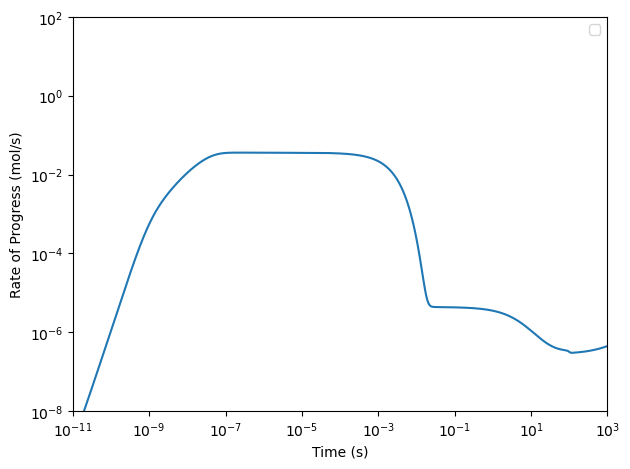

In [41]:
# Plots the ROP of O=CO
clf()

plot(t_vals, ROP_vals)

xscale("log")
xlim(1e-11,1e3)
yscale("log")
ylim(1e-8,1e2)
xlabel("Time (s)")
ylabel("Rate of Progress (mol/s)")
legend()
tight_layout()
gcf()

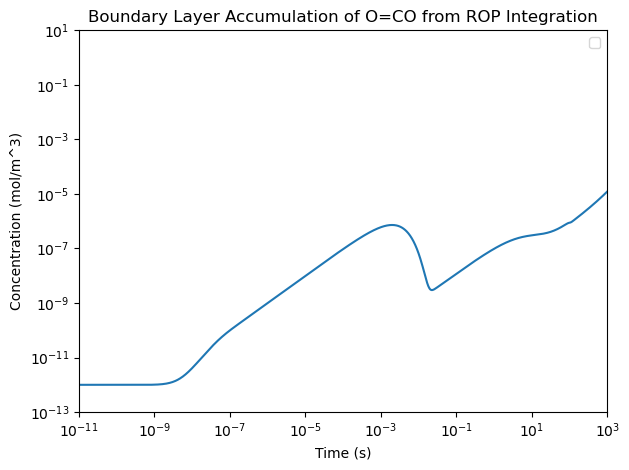

In [42]:
# Plots the Boundary Layer Concentration of O=CO from ROP Integration WITHOUT Diffusion Flux Into Reservoir
clf()

plot(t_vals, Cbl_vals)

xscale("log")
xlim(1e-11,1e3)
yscale("log")
ylim(1e-13,1e1)
xlabel("Time (s)")
ylabel("Concentration (mol/m^3)")
title("Boundary Layer Accumulation of O=CO from ROP Integration")
legend()
tight_layout()
gcf()

In [43]:
rops(ssys,"O=CO",1)

1507-element SparseArrays.SparseVector{Float64, Int64} with 13 stored entries:
  [1329]  =  3.51883e-6
  [1330]  =  6.67508e-27
  [1334]  =  3.30016e-24
  [1335]  =  3.19117e-20
  [1382]  =  1.47424e-31
  [1429]  =  -3.13886e-24
  [1466]  =  1.26125e-18
  [1476]  =  -3.47548e-41
  [1480]  =  3.86781e-39
  [1482]  =  -1.39325e-53
  [1495]  =  3.98532e-40
  [1498]  =  -6.95737e-42
  [1500]  =  2.9296e-38

In [44]:
fieldnames(typeof(ssys))

(:sol, :sims, :interfaces, :names, :species, :reactions, :p)

Net ROPs for species O=CO is: 0.011081939249267675
Showing the reaction with 1 th highest ROP for species O=CO:
vacantX+O=CO<=>CH2O2X
ROP = 0.011081939247853978
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 23373.5545874235
  n: Float64 0.49999999999977207
  Ea: Float64 1.418358411610997e-9
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 2 th highest ROP for species O=CO:
HX+O=CO<=>OC(O)[Pt]
ROP = 1.405972317009418e-12
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 11686.777293693782
  n: Float64 0.49999999999996975
  Ea: Float64 73060.00000000019
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 3 th highest ROP for species O=CO:
HX+O=CO<=>OCO[Pt]
ROP = 4.472145402079929e-15
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 11686.777293693782
  n: Float64 0.49999999999996975
  Ea: Float64 73060.00000000019
  unc: EmptyRateUncertainty EmptyRateUncertainty()

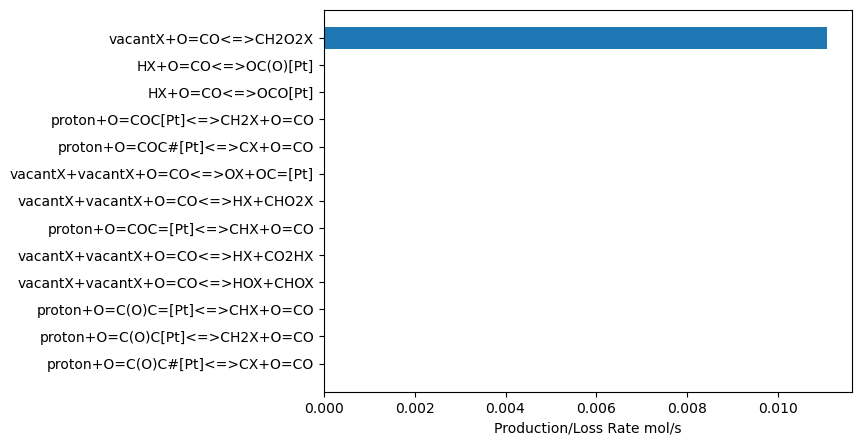

In [45]:
plotROP(ssys, "O=CO",1e-8;N=15,tol=0.0)

Net ROPs for species proton is: -5.9712645183068285e-6
Showing the reaction with 1 th highest ROP for species proton:
proton+CO2X<=>CHO2X
ROP = -3.909658832227069e-6
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e14
  n: Float64 0.0
  Ea: Float64 62276.629849940306
  q: Float64 0.25
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 2 th highest ROP for species proton:
proton+CO2X<=>CO2HX
ROP = -1.9749718464379574e-6
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 75249.98822394571
  q: Float64 0.5
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 3 th highest ROP for species proton:
proton+CO2HX<=>H2O+OCX
ROP = -4.255653013520114e-8
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 22584.872

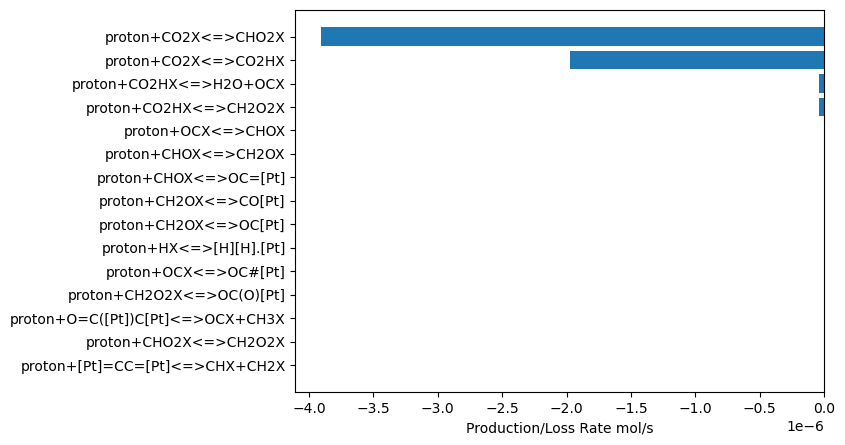

In [46]:
plotROP(ssys, "proton",1;N=15,tol=0.0)

Net ROPs for species O=CO is: 3.5188331343763696e-6
Showing the reaction with 1 th highest ROP for species O=CO:
vacantX+O=CO<=>CH2O2X
ROP = 3.5188331343750766e-6
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 23373.5545874235
  n: Float64 0.49999999999977207
  Ea: Float64 1.418358411610997e-9
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 2 th highest ROP for species O=CO:
HX+O=CO<=>OC(O)[Pt]
ROP = 1.2612537663989518e-18
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 11686.777293693782
  n: Float64 0.49999999999996975
  Ea: Float64 73060.00000000019
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 3 th highest ROP for species O=CO:
vacantX+vacantX+O=CO<=>HX+CO2HX
ROP = 3.191170302971873e-20
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 1.0188995025013999e9
  n: Float64 0.4999999999999998
  Ea: Float64 136711.0572887129
  unc: EmptyRateUncertainty Empt

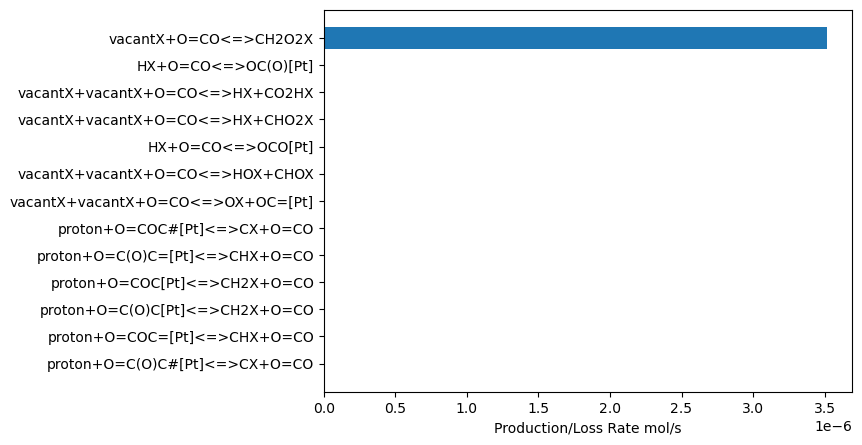

In [47]:
plotROP(ssys, "O=CO",1;N=15,tol=0.0)

Net ROPs for species CH2O2X is: 33256.74822959144
Showing the reaction with 1 th highest ROP for species CH2O2X:
CHO2X+CHO2X<=>CO2X+CH2O2X
ROP = 32491.88243204814
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 4.18e17
  n: Float64 0.0
  Ea: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 2 th highest ROP for species CH2O2X:
proton+CO2HX<=>CH2O2X
ROP = 650.6058223512374
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 48898.20910952611
  q: Float64 0.5
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 3 th highest ROP for species CH2O2X:
proton+CHO2X<=>CH2O2X
ROP = 88.30234913296361
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 3012.3559299445205
  q: Float64 0.5
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRa

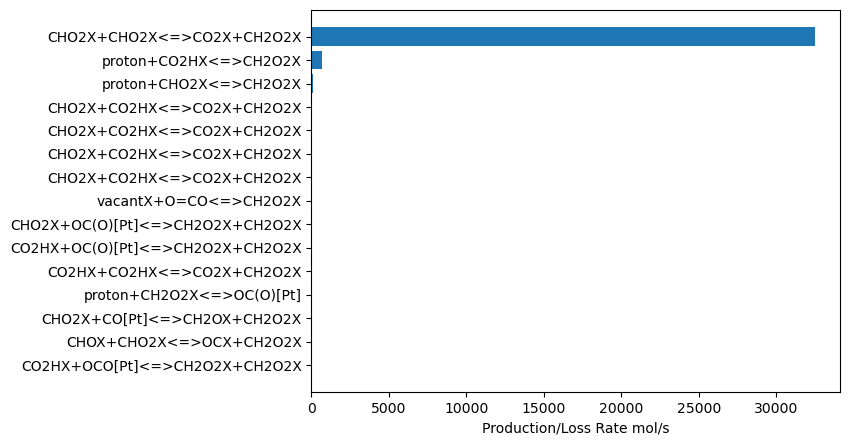

In [48]:
plotROP(ssys,"CH2O2X",1e-8;N=15,tol=0.0)

Net ROPs for species CHO2X is: 3.72379849332553e-13
Showing the reaction with 1 th highest ROP for species CHO2X:
proton+CO2X<=>CHO2X
ROP = 3.909658832227069e-6
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e14
  n: Float64 0.0
  Ea: Float64 62276.629849940306
  q: Float64 0.25
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 2 th highest ROP for species CHO2X:
CHO2X+CO2HX<=>CO2X+CH2O2X
ROP = -9.772876922410774e-7
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 4.18e17
  n: Float64 0.0
  Ea: Float64 26227.25171408696
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 3 th highest ROP for species CHO2X:
CHO2X+CO2HX<=>CO2X+CH2O2X
ROP = -9.772876922410774e-7
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 4.18e17
  n: Float64 0.0
  Ea: Float64 26227.25171408696
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing t

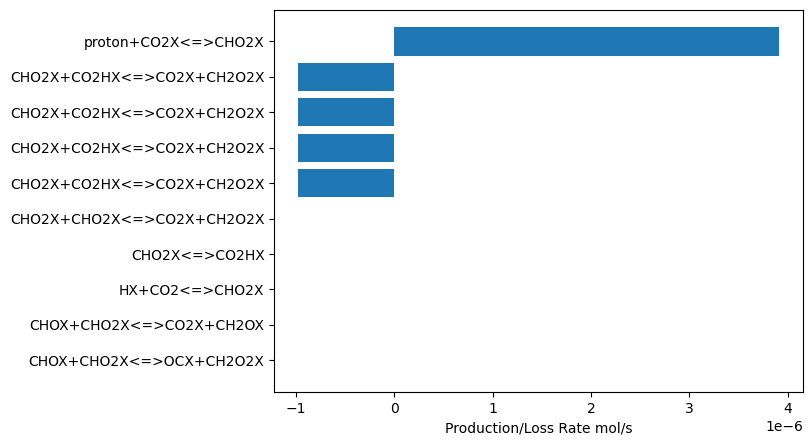

In [49]:
plotROP(ssys,"CHO2X",1;N=10,tol=0.0)

Net ROPs for species CO2HX is: -0.000111152266901548
Showing the reaction with 1 th highest ROP for species CO2HX:
CO2HX+CO2HX<=>CO2X+CH2O2X
ROP = -0.00010913316030959863
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 4.18e17
  n: Float64 0.0
  Ea: Float64 64984.89719971026
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 2 th highest ROP for species CO2HX:
proton+CO2X<=>CO2HX
ROP = 1.9749718464379574e-6
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 75249.98822394571
  q: Float64 0.5
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 3 th highest ROP for species CO2HX:
CHO2X+CO2HX<=>CO2X+CH2O2X
ROP = -9.772876922410774e-7
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 4.18e17
  n: Float64 0.0
  Ea: Float64 26227.25171408696
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing

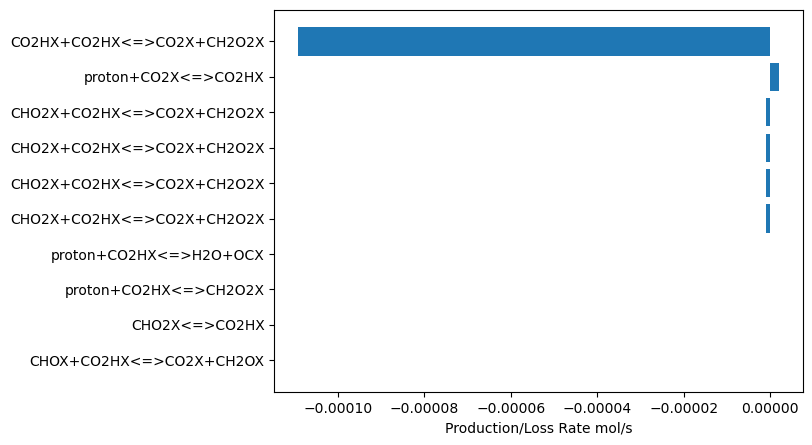

In [50]:
plotROP(ssys,"CO2HX",1;N=10,tol=0.0)

Net ROPs for species OX is: 3.82295046247797e-27
Showing the reaction with 1 th highest ROP for species OX:
OCX+CO[Pt]<=>OX+CC(=O)[Pt]
ROP = 6.911463830051847e-18
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 1.39e17
  n: Float64 0.101
  Ea: Float64 19000.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 2 th highest ROP for species OX:
OX+CHOX<=>HOX+OCX
ROP = -4.74159053410928e-18
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 3.298e17
  n: Float64 0.0
  Ea: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 3 th highest ROP for species OX:
vacantX+vacantX+CO2<=>OX+OCX
ROP = -2.178186060194617e-18
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 2.0839509572346687e8
  n: Float64 0.500000000000215
  Ea: Float64 188799.94201580161
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 4 th highest ROP for species OX:
OX+CC(

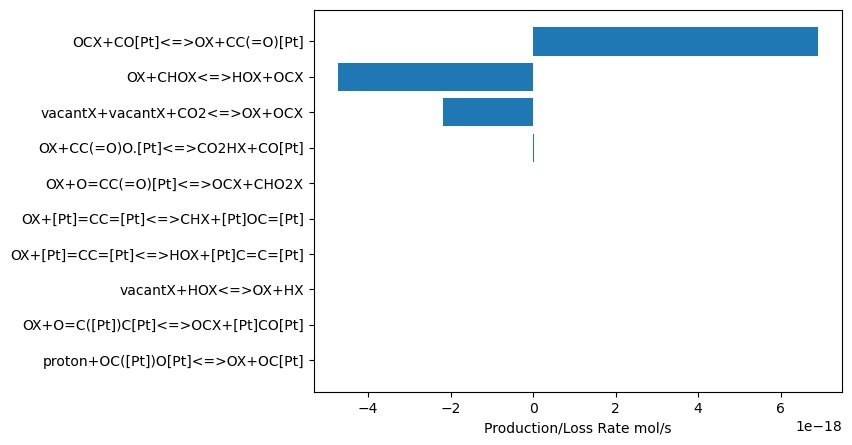

In [51]:
plotROP(ssys,"OX",1;N=10,tol=0.0)

Net ROPs for species OCX is: 0.0010823432798137006
Showing the reaction with 1 th highest ROP for species OCX:
CO2HX+OC=[Pt]<=>OCX+OC(O)[Pt]
ROP = 0.0010852207068393384
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 1.39e17
  n: Float64 0.101
  Ea: Float64 19000.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 2 th highest ROP for species OCX:
O=C([Pt])C=[Pt]<=>OCX+CHX
ROP = -2.8774270256379165e-6
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 4.22e12
  n: Float64 0.0
  Ea: Float64 104000.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()



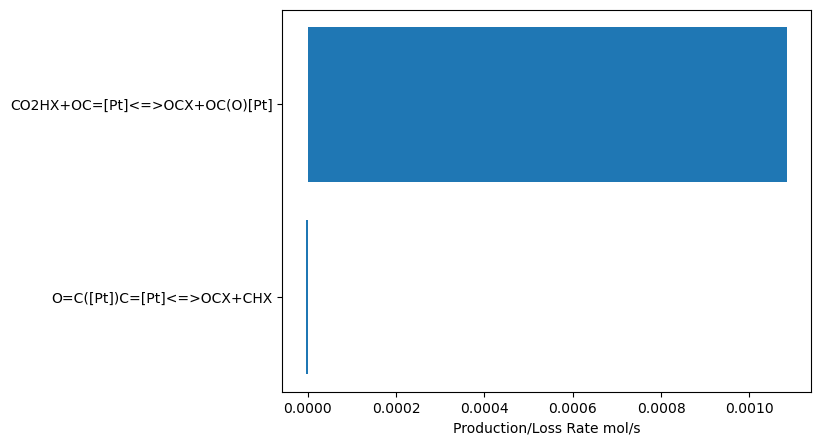

In [52]:
plotROP(ssys,"OCX",1.0e-6)

In [53]:
concentrations(ssys,"O=CO",1)

2.086079162408844e-6

In [54]:
ssys.sol

retcode: Success
Interpolation: 3rd order Hermite
t: 3402-element Vector{Float64}:
    0.0
    1.5219934681649523e-18
    8.633547368488198e-17
    9.344702758520521e-16
    1.7826050780192224e-15
    2.6307398801863927e-15
    3.920199324331331e-15
    6.027873627295679e-15
    9.528803114914393e-15
    1.498608205811249e-14
    ⋮
  828.1715751387352
  850.638780346129
  873.1059855535228
  895.5731907609166
  918.0403959683105
  940.5076011757043
  962.9748063830981
  985.4420115904919
 1000.0
u: 3402-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 360.0, 0.0036, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 359.99999999999983, 0.003599999999780525, 0.0, 9.945212408385767e-40, 3.77878100593239e-41, 1.1070000459093474e-122  …  1.8050027813578834e-182, 3.5814210458429026e-136, 0.0, 0.0, 6.44159813871022e-96, 1.689468624297892e-84, 7.453336270420498e-92, 9.825753070303532e-87, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 359.9999999999915, 0.00

In [55]:
ssys.sol.u[end]

101-element Vector{Float64}:
   0.0
   0.0
   0.0
   0.0
 359.85219562739746
   6.843598000707862e-14
   0.0
   1.1821326330881503e-7
   0.0002684723867591372
   1.831844848433086e-29
   ⋮
   4.388141335260565e-24
   1.8170014244066425e-39
   8.571859580959724e-44
   1.1146963872799234e-11
   5.1271507572973846e-26
   1.1379753096206066e-37
   3.1331880630097797e-56
   3.13762505008848e-11
   7.081371024511209e-14

In [56]:
ssys.interfaces[1].rxnarray

8×191 Matrix{Int64}:
 26   6   6   6   6   6   6  26  31  …   6   6    6    6    6    6    6  26
  5  27  27  28  29  30  33  26   6     99  99   90  100  100  100  101  26
  0   0   0   0   0   0   0   5   0      0   0    0    0    0    0    0  25
  0   0   0   0   0   0   0   0   0      0   0    0    0    0    0    0   0
 27  28  29  32  32  33  34  31  35     40  98  100   54   40  101   54  45
  0   0   0   0   0   0   0  30   0  …   9   0    0   54   45    0   45  45
  0   0   0   0   0   0   0   0   0      0   0    0    0    0    0    0   0
  0   0   0   0   0   0   0   0   0      0   0    0    0    0    0    0   0